Spring 2022
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

CIE 555, Neural Networks and Deep Learning

University of Science and Technology, Zewail City

<br>

<h1 align="center"> Yawn detection Training Model </h3>

---

# Read the Dataset 

The data set is read directly from Kaggle to save the uploading. 

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download davidvazquezcic/yawn-dataset

 53% 9.00M/16.9M [00:00<00:00, 16.6MB/s]
100% 16.9M/16.9M [00:00<00:00, 27.4MB/s]


In [ ]:

!mkdir /content/yawn_no_yawn
!unzip /content/yawn-dataset.zip -d /content/yawn_no_yawn

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Split the data set into train, validation and test set.

In [ ]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/yawn_no_yawn", output="output",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False) # default values

Copying files: 5119 files [00:00, 9141.53 files/s]


In [ ]:

import os
import random 
from glob import glob
from pathlib import Path
DATASET_DIR = os.path.join("/content", "output")
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

all_data = [y for x in os.walk(TRAIN_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
all_labels = [os.path.basename(os.path.dirname(x)) for x in all_data]
print(len(all_data))
all_data[:10]

3582


['/content/output/train/no yawn/4108.jpg',
 '/content/output/train/no yawn/4215.jpg',
 '/content/output/train/no yawn/4206.jpg',
 '/content/output/train/no yawn/2913.jpg',
 '/content/output/train/no yawn/5265.jpg',
 '/content/output/train/no yawn/3031.jpg',
 '/content/output/train/no yawn/4002.jpg',
 '/content/output/train/no yawn/4678.jpg',
 '/content/output/train/no yawn/3391.jpg',
 '/content/output/train/no yawn/2803.jpg']

In [ ]:

import numpy as np
classes = np.unique(all_labels)
print(' Number of classes are ', len(classes))
print('class labels are :', classes)

 Number of classes are  2
class labels are : ['no yawn' 'yawn']


 Viewing 25 random samples and their labels from the dataset

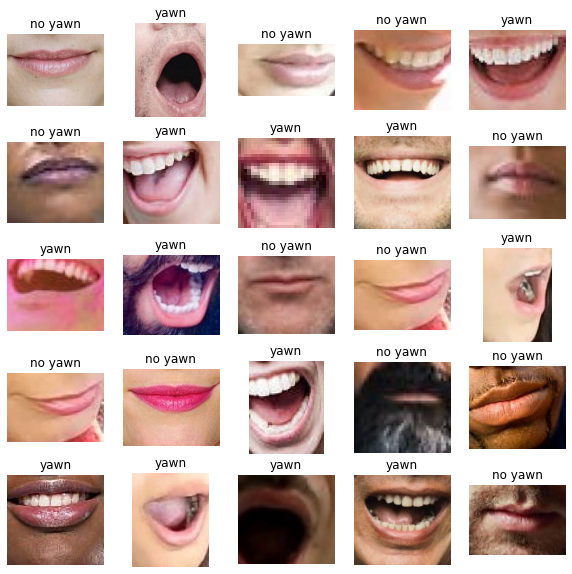

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# Sample 25 images from dataset
indices = np.random.randint(0, len(all_data), size=25)
images = [all_data[i] for i in indices]
labels = [all_labels[i] for i in indices]
# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(images[i]) # Read image from disk
    plt.imshow(image)
    # print(image.shape)
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

# Train, validation and test imagegenerator:



In [ ]:
# Image generator for the training set 

from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

BATCH_SIZE = 64
HEIGHT = 100
WIDTH = 100

train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
      rescale = 1.0/255,
      rotation_range = 20,
      brightness_range = [0.4 , 1.5 ],
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      vertical_flip = False, 
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    shuffle = True,
                                                    seed = 7,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

Found 3582 images belonging to 2 classes.


In [ ]:
# Image generator for the validation set 

VAL_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
      rescale = 1.0/255,
      rotation_range = 20,
      brightness_range = [0.4 , 1.5 ],
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      vertical_flip = False, # 
    )




val_generator = VAL_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True,
    seed = 7,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation')


Found 0 images belonging to 2 classes.


In [ ]:
# Image generator for the test set 


test_datagen =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
    )

test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical')

Found 770 images belonging to 2 classes.


# Model 1:

In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16


# Load model without classification head
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

Freeze the appropriate number of layers.



In [ ]:
# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
# Add new classifier layers

x = Flatten()(base_model.layers[-1].output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x) 

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)


model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Train the model

In [ ]:
import tensorflow as tf

INITIAL_EPOCHS = 15

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = INITIAL_EPOCHS)

Epoch 1/15
56/56 [==============================] - 26s 245ms/step - loss: 0.3884 - accuracy: 0.8492
Epoch 2/15
56/56 [==============================] - 13s 232ms/step - loss: 0.2382 - accuracy: 0.9076
Epoch 3/15
56/56 [==============================] - 13s 234ms/step - loss: 0.2077 - accuracy: 0.9221
Epoch 4/15
56/56 [==============================] - 13s 232ms/step - loss: 0.1809 - accuracy: 0.9358
Epoch 5/15
56/56 [==============================] - 13s 230ms/step - loss: 0.1846 - accuracy: 0.9338
Epoch 6/15
56/56 [==============================] - 13s 231ms/step - loss: 0.1674 - accuracy: 0.9403
Epoch 7/15
56/56 [==============================] - 13s 231ms/step - loss: 0.1598 - accuracy: 0.9428
Epoch 8/15
56/56 [==============================] - 13s 233ms/step - loss: 0.1540 - accuracy: 0.9433
Epoch 9/15
56/56 [==============================] - 13s 234ms/step - loss: 0.1529 - accuracy: 0.9464
Epoch 10/15
56/56 [==============================] - 13s 232ms/step - loss: 0.1583 - accura

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)


0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = base_learning_rate/10),
            loss='binary_crossentropy',
            metrics=['accuracy'])


Number of layers in the base model:  19


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)
FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten True
20 dense True
21 dropout True
22 dense_1 True
23 dense_2 True


In [ ]:

history_fine = model.fit(train_generator,
                        validation_data = val_generator,
                        initial_epoch=history.epoch[-1], # specify the initial value of epoch to start from when training
                        epochs = TOTAL_EPOCHS)

Epoch 15/20
56/56 [==============================] - 18s 270ms/step - loss: 0.1242 - accuracy: 0.9609
Epoch 16/20
56/56 [==============================] - 14s 252ms/step - loss: 0.1171 - accuracy: 0.9595
Epoch 17/20
56/56 [==============================] - 13s 233ms/step - loss: 0.0975 - accuracy: 0.9637
Epoch 18/20
56/56 [==============================] - 13s 234ms/step - loss: 0.0903 - accuracy: 0.9668
Epoch 19/20
56/56 [==============================] - 13s 234ms/step - loss: 0.0856 - accuracy: 0.9687
Epoch 20/20
56/56 [==============================] - 13s 233ms/step - loss: 0.0732 - accuracy: 0.9729


Saving the Model 

In [ ]:
# Saving the Model 
model.save('vgg16.h5')

Evaluation:

In [ ]:
model.evaluate(test_generator)

13/13 [==============================] - 2s 98ms/step - loss: 0.2131 - accuracy: 0.9416


[0.21314705908298492, 0.9415584206581116]

# Model 2:

In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16

# Load model without classification head
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [ ]:
# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
# Add new classifier layers

x = Flatten()(base_model.layers[-1].output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf

INITIAL_EPOCHS = 15

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = INITIAL_EPOCHS)

Epoch 1/15
56/56 [==============================] - 14s 232ms/step - loss: 0.4611 - accuracy: 0.8037
Epoch 2/15
56/56 [==============================] - 16s 279ms/step - loss: 0.2683 - accuracy: 0.9040
Epoch 3/15
56/56 [==============================] - 13s 231ms/step - loss: 0.2216 - accuracy: 0.9190
Epoch 4/15
56/56 [==============================] - 13s 232ms/step - loss: 0.2123 - accuracy: 0.9232
Epoch 5/15
56/56 [==============================] - 13s 239ms/step - loss: 0.1964 - accuracy: 0.9288
Epoch 6/15
56/56 [==============================] - 14s 257ms/step - loss: 0.1820 - accuracy: 0.9363
Epoch 7/15
56/56 [==============================] - 13s 230ms/step - loss: 0.1712 - accuracy: 0.9397
Epoch 8/15
56/56 [==============================] - 13s 232ms/step - loss: 0.1672 - accuracy: 0.9414
Epoch 9/15
56/56 [==============================] - 13s 231ms/step - loss: 0.1558 - accuracy: 0.9453
Epoch 10/15
56/56 [==============================] - 13s 232ms/step - loss: 0.1544 - accura

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)


0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = base_learning_rate/10),
            loss='binary_crossentropy',
            metrics=['accuracy'])


Number of layers in the base model:  19


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)
FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten_2 True
20 dense_6 True
21 dropout_2 True
22 dense_7 True
23 dropout_3 True
24 dense_8 True
25 dense_9 True


In [ ]:

history_fine = model.fit(train_generator,
                        validation_data = val_generator,
                        initial_epoch=history.epoch[-1], # specify the initial value of epoch to start from when training
                        epochs = TOTAL_EPOCHS)

Epoch 15/20
56/56 [==============================] - 15s 247ms/step - loss: 0.1333 - accuracy: 0.9509
Epoch 16/20
56/56 [==============================] - 13s 234ms/step - loss: 0.1193 - accuracy: 0.9609
Epoch 17/20
56/56 [==============================] - 13s 235ms/step - loss: 0.1039 - accuracy: 0.9645
Epoch 18/20
56/56 [==============================] - 13s 234ms/step - loss: 0.1026 - accuracy: 0.9643
Epoch 19/20
56/56 [==============================] - 13s 233ms/step - loss: 0.0832 - accuracy: 0.9693
Epoch 20/20
56/56 [==============================] - 13s 232ms/step - loss: 0.0856 - accuracy: 0.9701


Save the Model 

In [ ]:
# Saving the Model 
model.save('vgg16_yawn_2.h5')

In [ ]:
model.evaluate(test_generator)

13/13 [==============================] - 1s 71ms/step - loss: 0.2107 - accuracy: 0.9519


[0.2106793075799942, 0.9519480466842651]